# PAM50 overlap

In [1]:
PAM50 = "UBE2T BIRC5 NUF2 CDC6 CCNB1 TYMS MYBL2 CEP55 MELK NDC80 RRM2 UBE2C CENPF PTTG1 EXO1 ORC6L ANLN CCNE1 CDC20 MKI67 KIF2C ACTR3B MYC EGFR KRT5 PHGDH CDH3 MIA KRT17 FOXC1 SFRP1 KRT14 ESR1 SLC39A6 BAG1 MAPT PGR CXXC5 MLPH BCL2 MDM2 NAT1 FOXA1 BLVRA MMP11 GPR160 FGFR4 GRB7 TMEM45B ERBB2"
PAM50 = PAM50.split(' ')


In [3]:
def get_gene_sets(file_name):
    _set = []
    with open(f"../Legacy/Results/BRCA-pam/GSEA/{file_name}", "r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            _set.append(line)
    return _set

file_name = "order_DESeq2_wo_values.txt"
set_DE = get_gene_sets(file_name)[:100]

file_name = "order_MI_wo_values.txt"
set_MI = get_gene_sets(file_name)[:100]

file_name = "order_edgeR_wo_values.txt"
set_edgeR = get_gene_sets(file_name)[:100]

n_repet = 10
overlap_L1 = 0
overlap_L2 = 0
overlap_MLP = 0
overlap_GCN = 0

for exp in range(1, n_repet+1):

    file_name = f"order_IG_LR_L1_penalty_set_train_exp_{exp}_wo_values.txt"
    set_L1 = get_gene_sets(file_name)[:100]
    overlap_L1 += len(set(PAM50).intersection(set(set_L1)))

    file_name = f"order_IG_LR_L2_penalty_set_train_exp_{exp}_wo_values.txt"
    set_L2 = get_gene_sets(file_name)[:100]
    overlap_L2 += len(set(PAM50).intersection(set(set_L2)))

    file_name = f"order_IG_MLP_set_train_exp_{exp}_wo_values.txt"
    set_MLP = get_gene_sets(file_name)[:100]
    overlap_MLP += len(set(PAM50).intersection(set(set_MLP)))

    file_name = f"order_IG_GCN_set_train_exp_{exp}_wo_values.txt"
    set_GCN = get_gene_sets(file_name)[:100]
    overlap_GCN += len(set(PAM50).intersection(set(set_GCN)))
    

print("DE", len(set(PAM50).intersection(set(set_DE))))
print("MI", len(set(PAM50).intersection(set(set_MI))))
print("EdgeR", len(set(PAM50).intersection(set(set_edgeR))))
print("L1", overlap_L1 / n_repet)
print("L2", overlap_L2 / n_repet)
print("MLP", overlap_MLP / n_repet)
print("GCN", overlap_GCN / n_repet)               

DE 16
MI 20
EdgeR 7
L1 12.8
L2 11.7
MLP 9.6
GCN 6.2


# Customised plot for  over-representation analysis

In [1]:
import os
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams.update({"font.family": "Roboto Condensed"})


## Data



In [49]:
name = "pancan"
df = pd.read_excel(f"./GSEA/{name}.xlsx", index_col=0)
df = df.fillna(0)
df.head()


,DESeq2,EdgeR,MI,LR+L1,LR+L2,MLP,GNN
GOBP_VESICLE_MEDIATED_TRANSPORT [1541],1.0,0.0,0.0,0.0,0.0,0.0,0.0
GRAESSMANN_APOPTOSIS_BY_DOXORUBICIN_DN [1776],1.0,2.0,0.0,0.0,0.0,0.0,0.0
GOBP_CELL_CYCLE [1841],1.0,0.0,0.0,0.0,0.0,0.0,0.0
GOMF_PROTEIN_CONTAINING_COMPLEX_BINDING [1762],1.0,0.0,0.0,0.0,0.0,0.0,0.0
GOMF_TRANSCRIPTION_FACTOR_BINDING [599],1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Plot inspired by this example 
# https://python-graph-gallery.com/web-heatmap-and-radial-barchart-plastics/

# Methods
methods = ["DESeq2", "EdgeR", "MI", "LR+L1", "LR+L2", "MLP", "GNN"]
rename_methods = {"DESeq2":"DESeq2", "EdgeR": "EdgeR", "MI": "MI", "LR+L1":"LR+L1", "LR+L2":"LR+L2", "MLP":"MLP", "GNN":"GNN"}

# Define colors
COLORS = ["#0C2C84", "#225EA8", "#1D91C0", "#41B6C4", "#7FCDBB", "#C7E9B4", "#FFFFCC"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=256)

# Define colors
COLORS = ["#ffffff", "#225EA8", "#C7E9B4"]
# Create colormap
cmap = mcolors.LinearSegmentedColormap.from_list("colormap", COLORS, N=3)


def plot_heatmap(ax, methods, rename_methods, xlabel):
    # Get values for y axis
    y = list(df.index)

    # Limit the length of the values on the y axis
    for i in range(len(y)):
        # print(y[i])
        y[i] = y[i].strip()
        temp = y[i].split("[")
        if len(y[i]) <= 50:
            pass
        else:
            y[i] = y[i][:50 - len(temp[1]) - 2] + " [" + temp[1]
        # print(y[i])
        
    # Iterate over methods
    for i, method in enumerate(methods):
        # Select data for the given method
        d = df[rename_methods[method]]

        # Get values for the x axis
        x = [i] * len(y)
        
        # Generate colors.
        color = cmap(d.values.astype('int'))
        
        # Plot the markers
        ax.scatter(x, y, color=color, s=120, edgecolors="#ffffff")

    # Remove all spines
    ax.set_frame_on(False)

    # Set grid lines with some transparency
    ax.grid(alpha=0.4)

    # Make sure grid lines are behind other objects
    ax.set_axisbelow(True)

    # Set position for x ticks
    ax.set_xticks(np.arange(len(methods)))

    # Set labels for the x ticks (the names of the methods)
    ax.set_xticklabels(methods)

    # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
    ax.tick_params(size=0, colors="0.3")

    # Set label for horizontal axis.
    ax.set_xlabel(xlabel, loc="right")
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # Default vertical limits are shrunken by 0.75
    y_shrunk = 0.75
    y_lower, y_upper = ax.get_ylim()
    ax.set_ylim(y_lower + y_shrunk, y_upper - y_shrunk)
    
    # Revert axes
    plt.gca().invert_yaxis()
    
    return ax

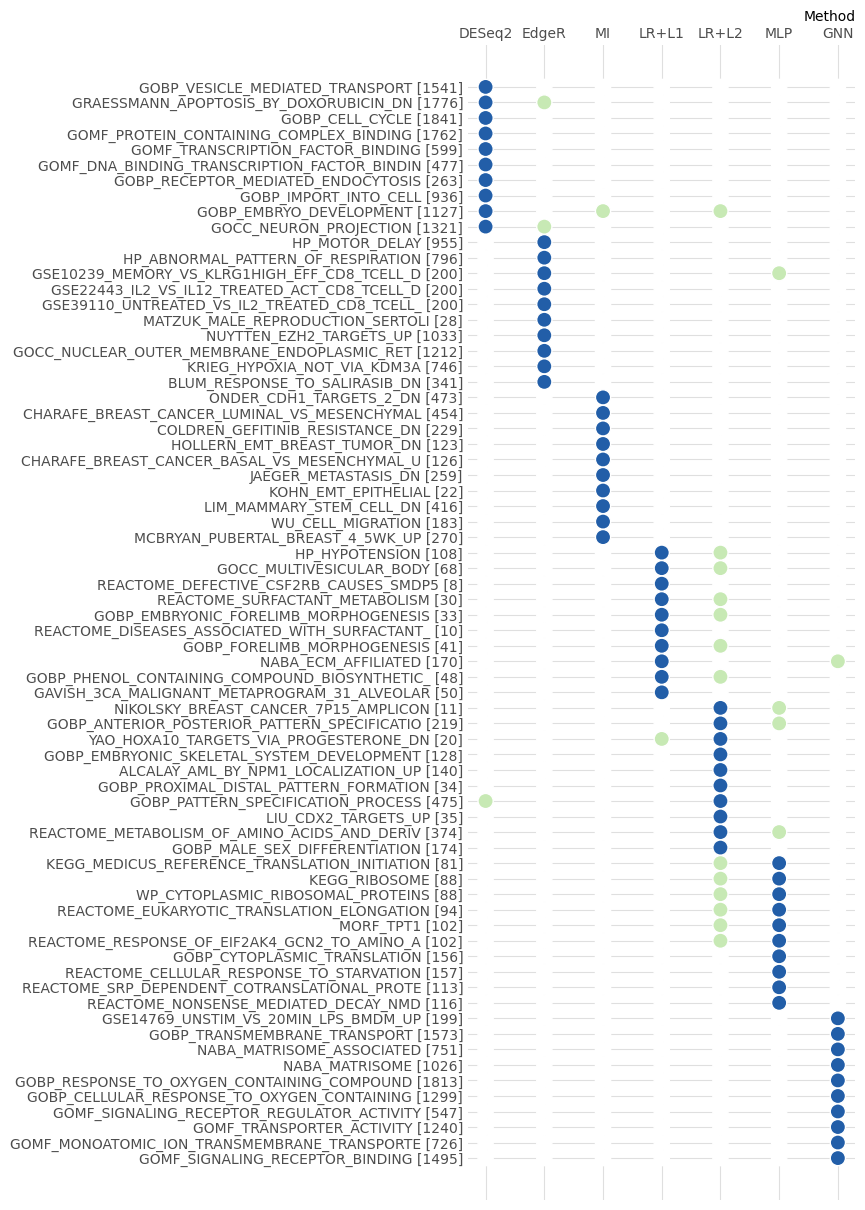

In [51]:
fig, ax = plt.subplots(figsize=(5, 15))
plot_heatmap(ax, methods, rename_methods, "Method")
plt.savefig(os.path.join(f"GSEA_{name}.png"), bbox_inches='tight')
plt.show()

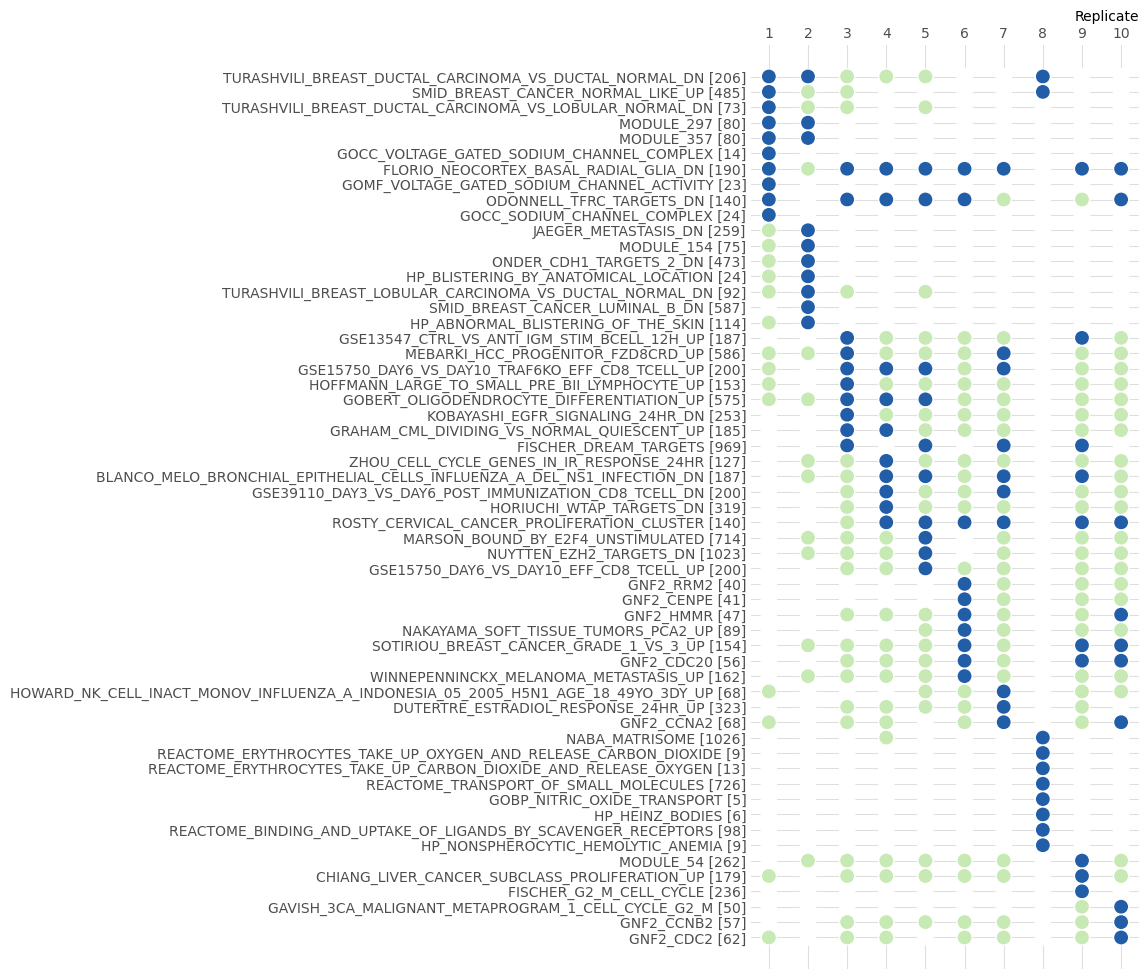

In [69]:
# methods = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
# rename_methods = {"1": "exp_1", "2": "exp_2", "3": "exp_3", "4": "exp_4", "5": "exp_5", "6": "exp_6", "7": "exp_7", "8": "exp_8", "9": "exp_9", "10": "exp_10"}
# fig, ax = plt.subplots(figsize=(5, 12))
# plot_heatmap(ax, methods, rename_methods, "Replicate")
# plt.savefig(os.path.join(f"GSEA_{name}.png"), bbox_inches='tight')
# plt.show()